So this one involves a bit of manual tweaking after the fact, but I also want to update this to have only hmmer hits, so it should make it less blue.
# Libraries

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(tidyverse)
library(ape)
library(readxl)
library(ggtree)
library(treeio) 

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: ggtree v3.2.0  For help: https://yulab-smu.top/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

1. Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpbi.96
2. Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for mapping and visualizing associated data on phylogeny using ggtree. Molecular Biology and Evolution. 2018, 35(12):3041-3043. doi:10.1093/molbev/msy194
3. Guangc

# Data

In [3]:
%%R
gtdb_tree <- read.tree("data/Enterobacterales_gtdb_bac120_r202.nwk")

In [4]:
%%R
assemblies <- read_excel("data/Enterobacterales_assembly_summary.xlsx", sheet = "Enterobacterales") %>%
	separate(`NCBI Organism Name`,c("g","s")) %>%
	unite("specific_epithet",c("g","s"))


In [5]:
%%R
samples <- read.table("data/Enterobacteriales_samples.txt", header = FALSE) %>%
	as.tibble() %>%
	rename(path = V1)
samples

# A tibble: 5,142 × 1
   path                                                                         
   <chr>                                                                        
 1 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 2 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 3 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 4 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 5 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 6 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 7 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 8 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 9 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
10 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
# … wi

In [31]:
%%R
all_best_hits <- read_csv("data/Enterobacteriales_all_best_hits.csv")

Rows: 16524 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): qseqid, sseqid, component, cinful_id, pephash, sample, contig, seq
dbl (13): pident, length, mismatch, gapopen, qstart, qend, sstart, send, eva...
lgl  (4): hmmerHit, verified, allStandardAA, signalMatch

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


I'll start with samples, because I need to have assembly ID and family name, which may take some fenagling because I think the fields are a bit mixed here.

In [6]:
%%R 
samples %>%
separate(path, c(NA,NA,NA,"f4"), sep = "/") %>%
	count(f4)

# A tibble: 4 × 2
  f4                          n
  <chr>                   <int>
1 Enterobacteriaceae_gtdb  4859
2 Pasteurellaceae_gtdb       68
3 Vibrionaceae_gtdb         143
4 refseq                     72


Yeah, exactly. I'll be ignoring refseq, and going straight to `Pasteurellaceae_gtdb` and `Vibrionaceae_gtdb`, though I will also need `other_families` from `Enterobacteriaceae_gtdb`.

So I'll just do outgroups and other_families separate, then merge them!

In [82]:
%%R 
outgroup_samples <- samples %>%
	separate(path, c(NA,NA,NA,"family_name",NA,NA,"ID"), sep = "/") %>%
	filter(family_name %in% c("Pasteurellaceae_gtdb","Vibrionaceae_gtdb")) %>% 
	mutate(family_name = str_replace_all(family_name, "_gtdb",""))
	# count(family_name)
outgroup_samples

# A tibble: 211 × 2
   family_name     ID             
   <chr>           <chr>          
 1 Pasteurellaceae GCF_000379785.1
 2 Pasteurellaceae GCF_901764995.1
 3 Pasteurellaceae GCF_013377275.1
 4 Pasteurellaceae GCF_011455495.1
 5 Pasteurellaceae GCF_002015035.1
 6 Pasteurellaceae GCF_900186835.1
 7 Pasteurellaceae GCF_014202395.1
 8 Pasteurellaceae GCF_011455875.1
 9 Pasteurellaceae GCF_000188255.1
10 Pasteurellaceae GCF_900450705.1
# … with 201 more rows


In [8]:
%%R
other_family_samples <- samples %>%
	separate(path, c(NA,NA,NA,"f4","f5","family_name",NA,NA,"ID"), sep = "/") %>% 
		filter(f4 == "Enterobacteriaceae_gtdb") %>%
		filter(f5 == "other_families") %>%
		select(family_name, ID)
other_family_samples

# A tibble: 85 × 2
   family_name       ID             
   <chr>             <chr>          
 1 Pectobacteriaceae GCF_000406145.1
 2 Pectobacteriaceae GCF_002291445.1
 3 Pectobacteriaceae GCF_000365305.1
 4 Pectobacteriaceae GCF_001644705.1
 5 Pectobacteriaceae GCF_001038685.1
 6 Pectobacteriaceae GCF_000406165.1
 7 Pectobacteriaceae GCF_000688655.1
 8 Pectobacteriaceae GCF_000400505.1
 9 Pectobacteriaceae GCF_900129615.1
10 Pectobacteriaceae GCF_000406105.1
# … with 75 more rows


In [83]:
%%R 
Enterobacterales_samples <- other_family_samples %>%
	full_join(outgroup_samples)
Enterobacterales_samples

Joining, by = c("family_name", "ID")
# A tibble: 296 × 2
   family_name       ID             
   <chr>             <chr>          
 1 Pectobacteriaceae GCF_000406145.1
 2 Pectobacteriaceae GCF_002291445.1
 3 Pectobacteriaceae GCF_000365305.1
 4 Pectobacteriaceae GCF_001644705.1
 5 Pectobacteriaceae GCF_001038685.1
 6 Pectobacteriaceae GCF_000406165.1
 7 Pectobacteriaceae GCF_000688655.1
 8 Pectobacteriaceae GCF_000400505.1
 9 Pectobacteriaceae GCF_900129615.1
10 Pectobacteriaceae GCF_000406105.1
# … with 286 more rows


In [84]:
%%R
Enterobacterales_samples %>% 
	count(family_name)

# A tibble: 8 × 2
  family_name           n
  <chr>             <int>
1 Budviciaceae          3
2 Erwiniaceae          20
3 Hafniaceae            8
4 Morganellaceae       15
5 Pasteurellaceae      68
6 Pectobacteriaceae    12
7 Vibrionaceae        143
8 Yersiniaceae         27


Alright, now I see the mistake! I really need to use %in% and not == there.

In [10]:
%%R
write_csv(Enterobacterales_samples,'data/supplemental/Enterobacterales_genome_samples.csv')

So I have the samples sorted out now. I think I can join that information with assemblies_summary to get the species information, which I will need for mapping to the phylogeny.

In [85]:
%%R
assemblies_sp_ID <- assemblies %>%
	right_join(Enterobacterales_samples) 
	# filter(ID %in% all_samples$ID) #%>%
	# count(family_name)
assemblies_sp_ID

Joining, by = "ID"
# A tibble: 296 × 14
   ID     specific_epithet  `NCBI Taxonomy`   `GTDB Taxonomy`   `GTDB species r…
   <chr>  <chr>             <chr>             <chr>             <chr>           
 1 GCF_0… Erwinia_tasmanie… d__Bacteria; p__… d__Bacteria; p__… yes             
 2 GCF_0… Erwinia_pyrifoli… d__Bacteria; p__… d__Bacteria; p__… yes             
 3 GCF_0… Providencia_rust… d__Bacteria; p__… d__Bacteria; p__… yes             
 4 GCF_0… Proteus_mirabilis d__Bacteria; p__… d__Bacteria; p__… yes             
 5 GCF_0… Vibrio_caribbean… d__Bacteria; p__… d__Bacteria; p__… yes             
 6 GCF_0… Providencia_alca… d__Bacteria; p__… d__Bacteria; p__… yes             
 7 GCF_0… Yersinia_aldovae  d__Bacteria; p__… d__Bacteria; p__… yes             
 8 GCF_0… Yersinia_rohdei   d__Bacteria; p__… d__Bacteria; p__… yes             
 9 GCF_0… Actinobacillus_m… d__Bacteria; p__… d__Bacteria; p__… yes             
10 GCF_0… Vibrio_coralliil… d__Bacteria; p__… d__Bacteria; p__… yes  

In [86]:
%%R
assemblies_sp_ID %>%
	count(family_name)

# A tibble: 8 × 2
  family_name           n
  <chr>             <int>
1 Budviciaceae          3
2 Erwiniaceae          20
3 Hafniaceae            8
4 Morganellaceae       15
5 Pasteurellaceae      68
6 Pectobacteriaceae    12
7 Vibrionaceae        143
8 Yersiniaceae         27


The only weird thing is that the Vibrio number is about half what it used to be, but I think that is right. The previous number may have been samples intended to download, and this may be the number that was able to be retrieved. If it cleans up the figure a bit, I'm fine with it!

ALright, so maybe I shouldn't be fine with it?? I definitely think it needs to be 


Now we can start working with the tree

In [87]:
%%R 
gtdb_tree_ID <- gtdb_tree$tip.label %>%
	as.tibble() %>%
	separate(value, c(NA, "a","b"), remove = FALSE, sep = "_") %>%
	unite("ID", c(a,b)) %>%
	mutate(ID = str_replace_all(ID, "'","")) %>%
	filter(ID %in% assemblies_sp_ID$ID)
gtdb_tree_ID

# A tibble: 296 × 2
   value                ID             
   <chr>                <chr>          
 1 'RS_GCF_001598475.1' GCF_001598475.1
 2 'RS_GCF_004792415.1' GCF_004792415.1
 3 'RS_GCF_006494375.1' GCF_006494375.1
 4 'RS_GCF_000710035.2' GCF_000710035.2
 5 'RS_GCF_008801695.1' GCF_008801695.1
 6 'RS_GCF_002095575.1' GCF_002095575.1
 7 'RS_GCF_002095465.1' GCF_002095465.1
 8 'RS_GCF_002095475.1' GCF_002095475.1
 9 'RS_GCF_014155765.1' GCF_014155765.1
10 'RS_GCF_000439375.1' GCF_000439375.1
# … with 286 more rows


In [88]:
%%R
gtdb_tree$tip.label %>%
	as.tibble() 

# A tibble: 45,555 × 1
   value               
   <chr>               
 1 'RS_GCF_001020875.1'
 2 'RS_GCF_902498005.1'
 3 'RS_GCF_014472415.1'
 4 'RS_GCF_002813455.1'
 5 'RS_GCF_009764645.1'
 6 'RS_GCF_000282515.1'
 7 'RS_GCF_001269815.1'
 8 'RS_GCF_004124275.1'
 9 'RS_GCF_009834515.1'
10 'RS_GCF_001297015.1'
# … with 45,545 more rows


In [89]:
%%R
gtdb_tree_subset <- drop.tip(gtdb_tree,gtdb_tree$tip.label[-match(gtdb_tree_ID$value, gtdb_tree$tip.label)])

In [90]:
%%R
gtdb_tree_subset$tip.label %>%
	as.tibble() 

# A tibble: 296 × 1
   value               
   <chr>               
 1 'RS_GCF_001598475.1'
 2 'RS_GCF_004792415.1'
 3 'RS_GCF_006494375.1'
 4 'RS_GCF_000710035.2'
 5 'RS_GCF_008801695.1'
 6 'RS_GCF_002095575.1'
 7 'RS_GCF_002095465.1'
 8 'RS_GCF_002095475.1'
 9 'RS_GCF_014155765.1'
10 'RS_GCF_000439375.1'
# … with 286 more rows


Plotting this took too long, so I worry that it may not be doing what I think it needs to be doing. So, I need to make sure the subset really is a smaller subset.

yeah, so something definitely happened that isn't very good, it isn't subsetting!

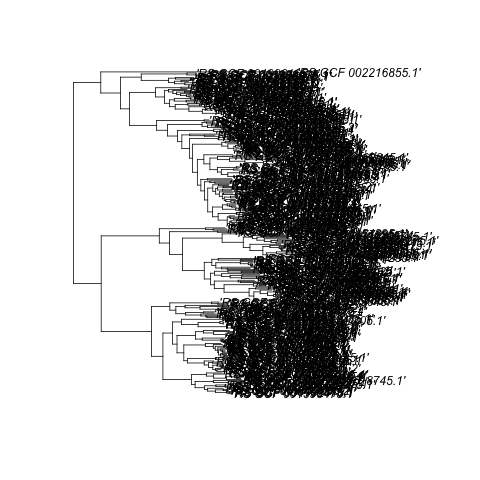

In [91]:
%%R
plot(gtdb_tree_subset)

In [92]:
%%R 
write.tree(gtdb_tree_subset,"data/supplemental/Enterobacteriales_gtdb_tree_subset.tree")

Much better! Now the annoying bit of going through the best hits and doing the same thing of splitting between outgroups and other_families, give them an ID column, and then merge them

In [94]:
%%R
outgroup_best_hits <- all_best_hits %>%
	# select(cinful_id) %>%
	separate(cinful_id, c("family_name",NA,NA,"ID"), sep = "/", remove = FALSE) %>% 
	mutate(family_name = str_replace_all(family_name, "_gtdb","")) %>%
	filter(family_name %in% c("Pasteurellaceae","Vibrionaceae")) #%>%
	# count(ID)
outgroup_best_hits

# A tibble: 204 × 27
   qseqid       sseqid  pident length mismatch gapopen qstart  qend sstart  send
   <chr>        <chr>    <dbl>  <dbl>    <dbl>   <dbl>  <dbl> <dbl>  <dbl> <dbl>
 1 v1_PLS_1aaf… L_tr_Q…   41.7     24       14       0     14    37     70    93
 2 v1_PLS_b887… S_tr_H…   29.3     58       39       1     43   100     27    82
 3 v1_PLS_3424… M_tr_Q…   36.1     36       23       0     10    45      7    42
 4 v1_PLS_5bef… S_tr_H…   25.9     58       41       1     43   100     27    82
 5 v1_PLS_9783… E492_s…   36.7     30       17       2      9    36     61    90
 6 v1_PLS_ed99… N_tr_C…   37.5     24       15       0     30    53      5    28
 7 v1_PLS_22e4… S_tr_H…   29.3     58       39       1     43   100     27    82
 8 v1_PLS_1cf1… I47_tr…   43.5     23       13       0     15    37      1    23
 9 v1_PLS_9835… S_tr_H…   25.9     58       41       1     43   100     27    82
10 v1_PLS_712c… S_tr_H…   60       15        6       0      1    15      4    18
# … wit

In [95]:
%%R 
other_family_best_hits <- all_best_hits %>%
	# select(cinful_id) %>%
	separate(cinful_id, c("f1","f2","family_name",NA,NA,"ID"), sep = "/", remove =FALSE) %>%
	filter(f1 == "Enterobacteriaceae_gtdb") %>%
	filter(f2 == "other_families") %>%
	select(-f1,-f2)
	# count(family_name)
other_family_best_hits

# A tibble: 221 × 27
   qseqid       sseqid  pident length mismatch gapopen qstart  qend sstart  send
   <chr>        <chr>    <dbl>  <dbl>    <dbl>   <dbl>  <dbl> <dbl>  <dbl> <dbl>
 1 v1_PLS_27c2… L_tr_Q…   55.3     47       21       0      1    47      1    47
 2 v1_PLS_6758… V_sp_P…   40.6     32       19       0      1    32      1    32
 3 v1_PLS_e0e0… PDI_tr…   35.2     88       48       3      1    81      4    89
 4 v1_PLS_7e97… N_tr_C…   46.4     28       13       1      1    28      1    26
 5 v1_PLS_1819… S_tr_H…   27.8     97       59       5      1    95      4    91
 6 v1_PLS_4147… PDI_tr…   61.1     18        7       0      3    20      4    21
 7 v1_PLS_ce31… S_tr_H…   40.9     44       22       1     18    61     49    88
 8 v1_PLS_c370… N_tr_C…   35.7     42       27       0     27    68      2    43
 9 v1_PLS_ddb6… S_tr_H…   34.5    116       66       4      1   106      4   119
10 v1_PLS_37fd… PDI_tr…   69.6     23        7       0      2    24      4    26
# … wit

In [96]:
%%R 

Enterobacteriales_best_hits <- other_family_best_hits %>%
	full_join(outgroup_best_hits)
	

Joining, by = c("qseqid", "sseqid", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore", "component", "hmmerHit", "verified", "cinful_id", "family_name", "ID", "pephash", "sample", "contig", "start", "stop", "strand", "allStandardAA", "seq", "signalMatch")


In [97]:
%%R
Enterobacteriales_best_hits_microcin <- Enterobacteriales_best_hits %>%
	filter(component == "microcins.verified")

In [107]:
%%R
Enterobacteriales_best_hits_microcin_hmmer <- Enterobacteriales_best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE)

FYI, when I get to the point where I want to update it to only included hmmer hits, this is where I would add that filter.

In [98]:
%%R
assemblies_sp_ID_microcin <- assemblies_sp_ID %>%
	mutate(has_micrcocin = ID %in% Enterobacteriales_best_hits_microcin$ID)
assemblies_sp_ID_microcin

# A tibble: 296 × 15
   ID     specific_epithet  `NCBI Taxonomy`   `GTDB Taxonomy`   `GTDB species r…
   <chr>  <chr>             <chr>             <chr>             <chr>           
 1 GCF_0… Erwinia_tasmanie… d__Bacteria; p__… d__Bacteria; p__… yes             
 2 GCF_0… Erwinia_pyrifoli… d__Bacteria; p__… d__Bacteria; p__… yes             
 3 GCF_0… Providencia_rust… d__Bacteria; p__… d__Bacteria; p__… yes             
 4 GCF_0… Proteus_mirabilis d__Bacteria; p__… d__Bacteria; p__… yes             
 5 GCF_0… Vibrio_caribbean… d__Bacteria; p__… d__Bacteria; p__… yes             
 6 GCF_0… Providencia_alca… d__Bacteria; p__… d__Bacteria; p__… yes             
 7 GCF_0… Yersinia_aldovae  d__Bacteria; p__… d__Bacteria; p__… yes             
 8 GCF_0… Yersinia_rohdei   d__Bacteria; p__… d__Bacteria; p__… yes             
 9 GCF_0… Actinobacillus_m… d__Bacteria; p__… d__Bacteria; p__… yes             
10 GCF_0… Vibrio_coralliil… d__Bacteria; p__… d__Bacteria; p__… yes             
# … wit

In [108]:
%%R
assemblies_sp_ID_microcin_hmmer <- assemblies_sp_ID %>%
	mutate(has_micrcocin = ID %in% Enterobacteriales_best_hits_microcin_hmmer$ID)
assemblies_sp_ID_microcin_hmmer

# A tibble: 296 × 15
   ID     specific_epithet  `NCBI Taxonomy`   `GTDB Taxonomy`   `GTDB species r…
   <chr>  <chr>             <chr>             <chr>             <chr>           
 1 GCF_0… Erwinia_tasmanie… d__Bacteria; p__… d__Bacteria; p__… yes             
 2 GCF_0… Erwinia_pyrifoli… d__Bacteria; p__… d__Bacteria; p__… yes             
 3 GCF_0… Providencia_rust… d__Bacteria; p__… d__Bacteria; p__… yes             
 4 GCF_0… Proteus_mirabilis d__Bacteria; p__… d__Bacteria; p__… yes             
 5 GCF_0… Vibrio_caribbean… d__Bacteria; p__… d__Bacteria; p__… yes             
 6 GCF_0… Providencia_alca… d__Bacteria; p__… d__Bacteria; p__… yes             
 7 GCF_0… Yersinia_aldovae  d__Bacteria; p__… d__Bacteria; p__… yes             
 8 GCF_0… Yersinia_rohdei   d__Bacteria; p__… d__Bacteria; p__… yes             
 9 GCF_0… Actinobacillus_m… d__Bacteria; p__… d__Bacteria; p__… yes             
10 GCF_0… Vibrio_coralliil… d__Bacteria; p__… d__Bacteria; p__… yes             
# … wit

In [99]:
%%R 
assemblies_sp_ID_microcin %>%
	count(family_name, has_micrcocin)

# A tibble: 15 × 3
   family_name       has_micrcocin     n
   <chr>             <lgl>         <int>
 1 Budviciaceae      TRUE              3
 2 Erwiniaceae       FALSE            11
 3 Erwiniaceae       TRUE              9
 4 Hafniaceae        FALSE             6
 5 Hafniaceae        TRUE              2
 6 Morganellaceae    FALSE            11
 7 Morganellaceae    TRUE              4
 8 Pasteurellaceae   FALSE            56
 9 Pasteurellaceae   TRUE             12
10 Pectobacteriaceae FALSE            11
11 Pectobacteriaceae TRUE              1
12 Vibrionaceae      FALSE           117
13 Vibrionaceae      TRUE             26
14 Yersiniaceae      FALSE             4
15 Yersiniaceae      TRUE             23


In [100]:
%%R 
assemblies_sp_treeID_microcin <- assemblies_sp_ID_microcin %>%
	filter(has_micrcocin == TRUE) %>%
	left_join(gtdb_tree_ID)
assemblies_sp_treeID_nonmicrocin <- assemblies_sp_ID_microcin %>%
	filter(has_micrcocin == FALSE) %>%
	left_join(gtdb_tree_ID)

Joining, by = "ID"
Joining, by = "ID"


In [109]:
%%R 
assemblies_sp_treeID_microcin_hmmer <- assemblies_sp_ID_microcin_hmmer %>%
	filter(has_micrcocin == TRUE) %>%
	left_join(gtdb_tree_ID)
assemblies_sp_treeID_nonmicrocin_hmmer <- assemblies_sp_ID_microcin_hmmer %>%
	filter(has_micrcocin == FALSE) %>%
	left_join(gtdb_tree_ID)

Joining, by = "ID"
Joining, by = "ID"


In [101]:
%%R

gtdb_tree_subset_microcin_labeled <- groupOTU(gtdb_tree_subset, .node=assemblies_sp_treeID_microcin$value, group_name="has_microcin")
gtdb_tree_subset_nonmicrocin_labeled <- groupOTU(gtdb_tree_subset, .node=assemblies_sp_treeID_nonmicrocin$value, group_name="has_no_microcin")

In [110]:
%%R

gtdb_tree_subset_microcin_hmmer_labeled <- groupOTU(gtdb_tree_subset, .node=assemblies_sp_treeID_microcin_hmmer$value, group_name="has_microcin")
gtdb_tree_subset_nonmicrocin_hmmer_labeled <- groupOTU(gtdb_tree_subset, .node=assemblies_sp_treeID_nonmicrocin_hmmer$value, group_name="has_no_microcin")

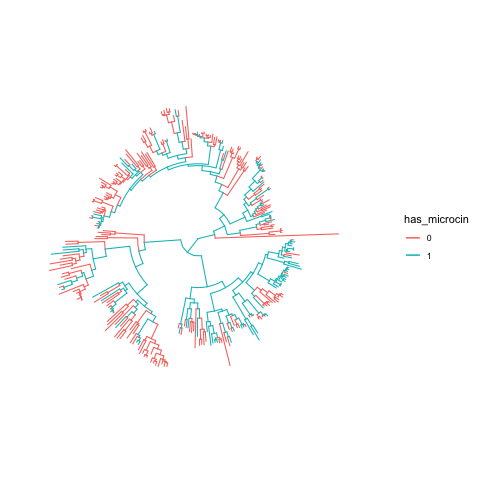

In [102]:
%%R 
ggtree(gtdb_tree_subset_microcin_labeled, layout="circular", aes(color=has_microcin))


	

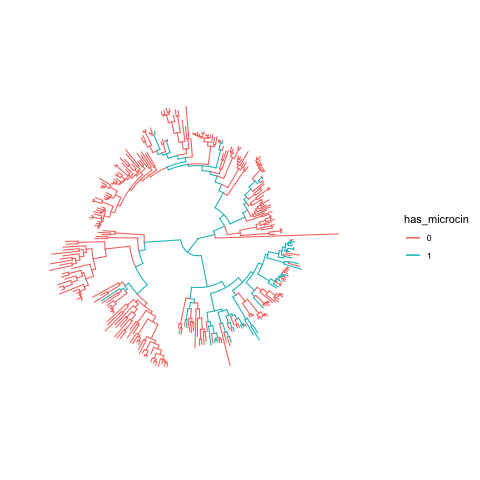

In [111]:
%%R 
ggtree(gtdb_tree_subset_microcin_hmmer_labeled, layout="circular", aes(color=has_microcin))


	

In [103]:
%%R 
gtdb_tree_ID_all_info <- gtdb_tree_ID %>%
	full_join(assemblies_sp_ID_microcin)

Joining, by = "ID"


In [112]:
%%R 
gtdb_tree_ID_all_info_hmmer <- gtdb_tree_ID %>%
	full_join(assemblies_sp_ID_microcin_hmmer)

Joining, by = "ID"


In [104]:
%%R 
gtdb_tree_subset_microcin_labeled_specific_epithet <- rename_taxa(gtdb_tree_subset_microcin_labeled, gtdb_tree_ID_all_info, value, specific_epithet)
gtdb_tree_subset_nonmicrocin_labeled_specific_epithet <- rename_taxa(gtdb_tree_subset_nonmicrocin_labeled, gtdb_tree_ID_all_info, value, specific_epithet)

In [113]:
%%R 
gtdb_tree_subset_microcin_hmmer_labeled_specific_epithet <- rename_taxa(gtdb_tree_subset_microcin_hmmer_labeled, gtdb_tree_ID_all_info_hmmer, value, specific_epithet)
gtdb_tree_subset_nonmicrocin_hmmer_labeled_specific_epithet <- rename_taxa(gtdb_tree_subset_nonmicrocin_hmmer_labeled, gtdb_tree_ID_all_info_hmmer, value, specific_epithet)

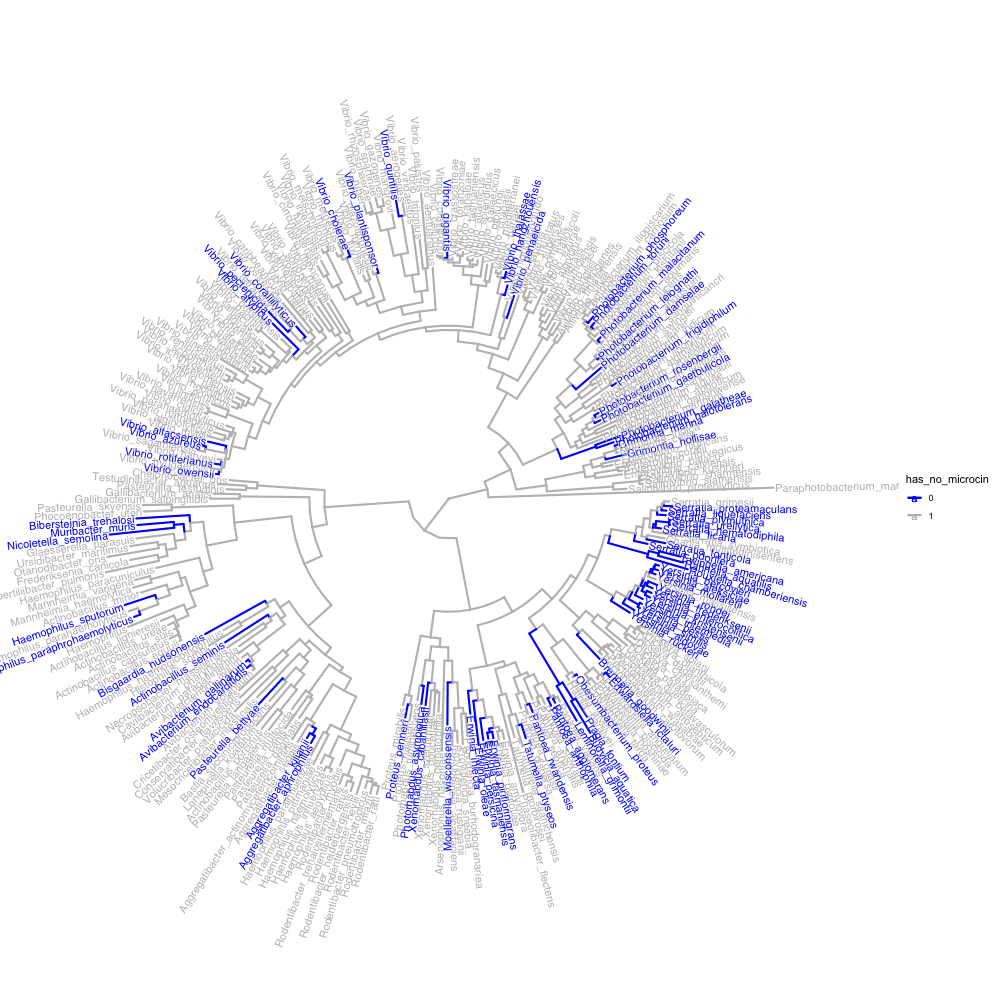

In [105]:
%%R -w 1000 -h 1000
gtdb_tree_subset_nonmicrocin_labeled_specific_epithet %>%
	ggtree(layout="circular", 
			aes(color=has_no_microcin),
			size=1
			) +
		geom_tiplab() +
		scale_color_manual(values=c("blue","gray"))



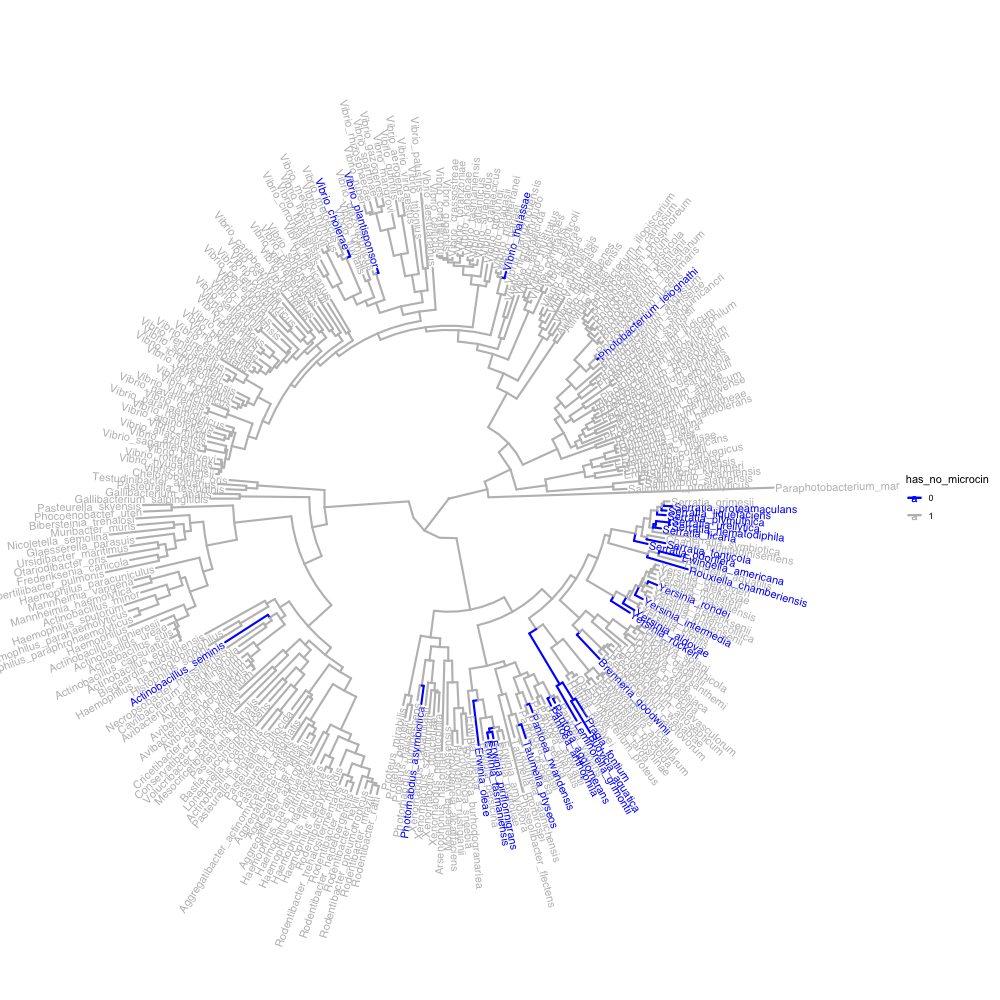

In [114]:
%%R -w 1000 -h 1000
gtdb_tree_subset_nonmicrocin_hmmer_labeled_specific_epithet %>%
	ggtree(layout="circular", 
			aes(color=has_no_microcin),
			size=1
			) +
		geom_tiplab() +
		scale_color_manual(values=c("blue","gray"))



In [115]:
%%R -w 1000 -h 1000
gtdb_tree_subset_nonmicrocin_hmmer_labeled_specific_epithet %>%
	ggtree(layout="circular", 
			aes(color=has_no_microcin),
			size=1
			) +
		geom_tiplab() +
		scale_color_manual(values=c("blue","gray"))

ggsave("plots/06_Enterobacteriales_microcin_phylogeny.svg")

R[write to console]: Saving 13.9 x 13.9 in image

